 # Stockman Silver Nanolens
 In this notebook we calculate the the optical spectra and local-field enhancement of Silver Nanolenses as proposed in the following publication:
 
 Li K, Stockman MI, Bergman DJ (2003) **Self-Similar Chain of Metal Nanospheres as an Efficient Nanolens.** *Phys Rev Lett* 91:227402. [doi:10.1103/PhysRevLett.91.227402](http://dx.doi.org/10.1103/PhysRevLett.91.227402)

The notebook is structured as follows:
 *  **Importing the libraries:** setup of useful settings and import of necessary libraries and databases.
 *  **Setting up the inputs:** definition of the inputs of the simulation.
 *  **Performing the calculations**: call to py_gmm to compute all the relevant far-field and local field quantities.
 *  **Plotting the results**: plot of the integral and differential cross-section for the far-field, and the field enhancement for the local-field.

# Importing the libraries

In [2]:
#------Library loading------

# numpy for matrix computations
import numpy as np; import numpy.ma as ma

# system libraries
import sys

# plotting libraries
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.patches import Circle, Ellipse

# Generalized Multiparticle Mie import
sys.path.append('../')
import py_gmm

# Setting up the inputs

### Target inputs (optical constant database, sphere coordinates, composition and size)

In [3]:
# building the optical constant database
eps_db_out=py_gmm.mat.generate_eps_db('../epsilon/',ext='*.edb')
eps_files,eps_names,eps_db=eps_db_out['eps_files'],eps_db_out['eps_names'],eps_db_out['eps_db']

# sphere position (in nm)
m_xyz = np.array([[  0. ,   0. ,   0. ],
                  [ 64.5,   0. ,   0. ],
                  [ 86. ,   0. ,   0. ]])

# sphere radius (in nm)
v_r = np.array([ 45.,  15.,   5.])

# how many spheres in the target? We guess it from the length of the radius vector
ns = len(v_r)

# sphere composition, calling the names contained in "eps_names", just populated above
target_comp= np.array(ns* ['eagJCf']) # vector containing the optical constants names

# refractive index of the environment
n_matrix = 1.00

### Plane wave incident field

In [4]:
# Euler angles: (alpha,beta,gamma)=(0,0,0) means a z-directed, x-polarized plane wave
alpha = 0.0   # azimuth
beta = 0.0  # polar
gamma = 0.0  # polarization

# Wavelengths for the specrum computation
wl_min = 300
wl_max = 500
n_wl = 250
v_wl = np.linspace(wl_min,wl_max,n_wl)

# Wavelength for the local field computation
wl_lf = 1240/3.25 # conversion from 3.37 eV

### Additional inputs for the simulation

In [5]:
n_stop=20 # maximum multipolar expansion order
f_int=0.0; # interaction cutoff (normally set to zero to have full interactions)
lf_ratio=300; # plot sphere local field contribution up to a distance equal to d=lf_ratio*r_sphere
qs_flag='yes' # use the quasi-static approximation for the current simulation
n_E = 400  # local field plotting grid resolution

### Target plot

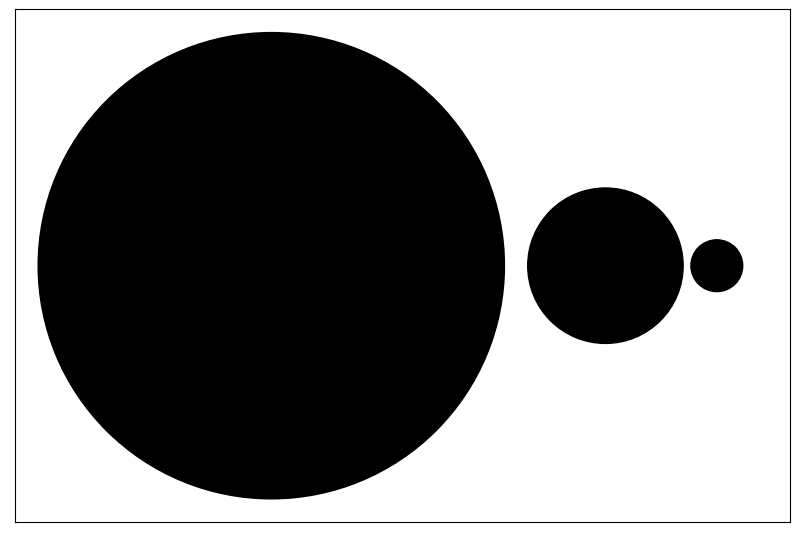

In [7]:
# target plot
fig = plt.figure(num=1,figsize=(10,10)) # setting the figure size
ax = fig.add_subplot(1, 1, 1, aspect='equal')  # creating the plotting axis

# plot bounds and eliminating x and y ticks
plt.xlim(-1.1*(v_r[0]),1.1*(m_xyz[ns-1,0]+v_r[ns-1]))
plt.ylim(-1.1*(v_r[0]),1.1*(v_r[0]))
plt.xticks([])
plt.yticks([])

# plotting the target
for c,r in zip(m_xyz,v_r):
    c0=c[0];c1=c[1];
    ax.add_patch(Circle((c0,c1),r,color='k'))

# Performing the calculations

### Scattering cross sections and field expansion coefficients for the spectral computation

In [8]:
# computing the expansion coefficients and cross sections with a loop
m_abcd_ext_sca_abs = []  # list to be filled with the output
for wl in v_wl:
    
    # retrieving optical constants at wl from the database
    e_list=py_gmm.mat.db_to_eps(wl,eps_db,target_comp);
    m_eps=np.column_stack((np.real(e_list),np.imag(e_list)));
    
    # solving the gmm problem (calculating the cross sections and the expansion coefficients)
    out=py_gmm.gmm_py.gmm_f2py_module.expansion_coefficients(m_xyz, # target sphere position in nm
                                                      v_r,   # target sphere radii in nm
                                                      m_eps, # e1 and e2 for each sphere
                                                      f_int,  # interaction coefficient
                                                      n_matrix, # environment refractive index
                                                      wl, # computation wavelength
                                                      alpha,beta,gamma, # euler angles for the incident pw
                                                      0, # =0 Linear, =1 Left Circular, =2 Right Circular
                                                      n_stop, # maximum number for expansion coefficients
                                                      qs_flag) # quasi static approximation
    m_abcd_ext_sca_abs.append(out)
    
# extracting coefficients and cross section
v_coeff=[];v_cext=[];v_csca=[];v_cabs=[];
for out in m_abcd_ext_sca_abs:
    v_coeff.append(out[0]);
    v_cext.append(out[1]);
    v_csca.append(out[2]);
    v_cabs.append(out[3]);

# converting the lists to numpy arrays
v_cext=np.array(v_cext)
v_csca=np.array(v_csca)
v_cabs=np.array(v_cabs)

### Local Field

In [9]:
# local field

# optical constants
e_list=py_gmm.mat.db_to_eps(wl_lf,eps_db,target_comp);
m_eps=np.column_stack((np.real(e_list),np.imag(e_list)));

# gmm coefficients computation
out=py_gmm.gmm_py.gmm_f2py_module.expansion_coefficients(m_xyz,  # target sphere position in nm
                                                         v_r,  # target sphere radii in nm
                                                         m_eps,  # e1 and e2 for each sphere
                                                         f_int,  # interaction coefficient
                                                         n_matrix,  # environment refractive index
                                                         wl_lf, # computation wavelength
                                                         alpha,beta,gamma,  # euler angles for the incident pw
                                                         0, # =0 Linear, =1 Left Circular, =2 Right Circular
                                                         n_stop,  # maximum number for expansion coefficients
                                                         qs_flag)  # quasi static approximation
v_amnbmn=out[0][:,0] # getting field expansion coefficients
v_dmncmn=out[0][:,1]

# local field
v_emn=py_gmm.gmm_py.gmm_f2py_module.emn(n_stop)[0] # normalization coeffs

# building plotting grid
x_min = -1.1*v_r[0]
x_max = 1.1*(m_xyz[ns-1,0]+v_r[ns-1])
y_min = -1.1*v_r[0]
y_max = 1.1*v_r[0]
v_x=np.linspace(x_min,x_max,n_E);
v_y=np.linspace(y_min,y_max,n_E);

# retrieving the local field
m_E=[]
for x in v_x:
    for y in v_y:
        out = py_gmm.gmm_py.gmm_f2py_module.exyz("yes", # include incident local field
                                                 n_stop,  # maximum number for expansion coefficients
                                                 0, # =0 Linear, =1 Left Circular, =2 Right Circular
                                                 lf_ratio,  # plot sphere contribution up to distance d=lf_ratio*r
                                                 wl_lf,  # computation wavelength 
                                                 alpha,beta,gamma,
                                                 x,y,0.0, # field computation coordinates
                                                 v_amnbmn,v_dmncmn,v_emn, # expansion and normalization coefficients
                                                 m_xyz,m_eps,v_r,  # sphere position, composition and size
                                                 n_matrix,  # environment refractive index 
                                                 qs_flag)  # quasi static approximation
        m_E=np.append(m_E,out[3])
m_E=np.array(m_E).reshape(n_E,n_E)

# Plotting the results

### Extinction cross section

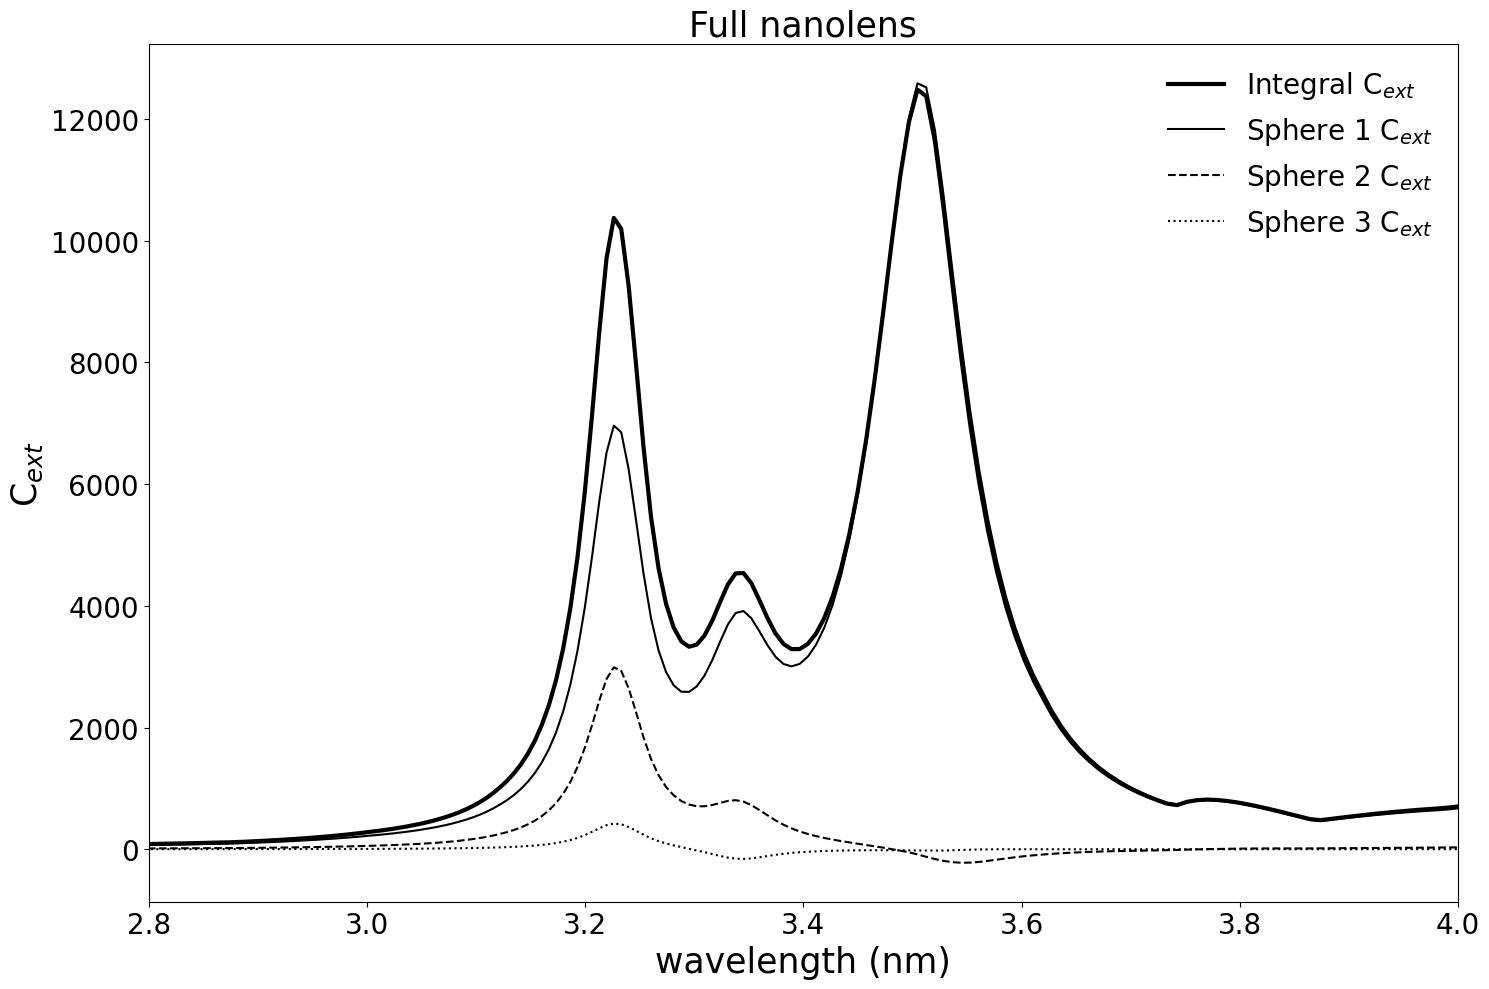

In [11]:
# cross section plot
f_size=25;
f_size_ticks=20;
plt.figure(1,figsize=(15,10));
plt.plot(1240/v_wl,np.sum(v_cext,axis=1),'k',linewidth=3.0);
plt.plot(1240/v_wl,v_cext[:,0],'k',
         1240/v_wl,v_cext[:,1],'k--',
         1240/v_wl,v_cext[:,2],'k:');

# plt title
plt.title('Full nanolens',fontsize=f_size)

# axes labels
plt.xlabel(r'wavelength (nm)', fontsize=f_size)
plt.ylabel(r'C$_{ext}$', fontsize=f_size)

# ticks
plt.xlim(2.8,4.0)
plt.xticks(fontsize=f_size_ticks)
plt.yticks(fontsize=f_size_ticks)

# legend
plt.legend((r'Integral C$_{ext}$',
            r'Sphere 1 C$_{ext}$',
            r'Sphere 2 C$_{ext}$',
            r'Sphere 3 C$_{ext}$'),frameon=False,fontsize=f_size-5)

# layout
plt.tight_layout()

### Local field enhancement

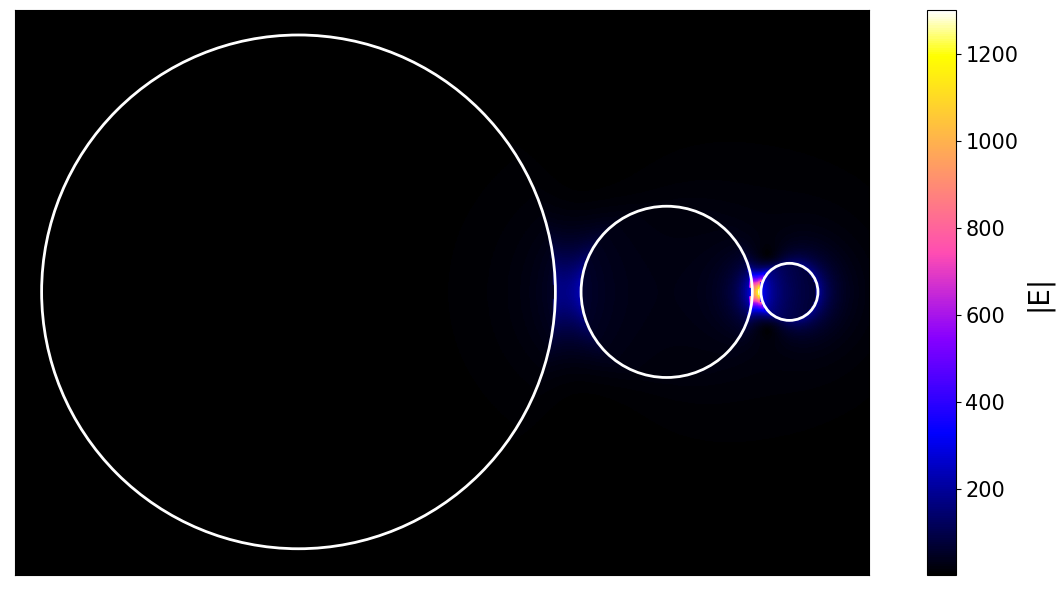

In [12]:
# local field plot
f_size = 25
fig = plt.figure(2,figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')  # creating the plotting axis
plt.imshow(m_E.T,origin='lower',cmap='gnuplot2', aspect=(y_max-y_min)/(x_max-x_min),vmax=1300)

# remove ticks
plt.xticks([])
plt.yticks([])

# colorbar
cb = plt.colorbar()
cb.set_label('|E|', fontsize=f_size-5)
cb.ax.tick_params(labelsize=f_size-10)
plt.tight_layout()

# sphere outlines
for c,r in zip(m_xyz,v_r):
    
    # aspect rations
    x_ar = n_E/(x_max-x_min)
    y_ar = n_E/(y_max-y_min)
    
    # circle centers
    c0=x_ar*(c[0]-x_min)
    c1=y_ar*(c[1]-y_min)
    ax.add_patch(Ellipse((c0,c1),2.0*r*x_ar,2.0*r*y_ar,facecolor='none',edgecolor='w',linewidth=2.0))